In [2]:
%load_ext autoreload
%autoreload 2
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [3]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

| using device: cpu


In [4]:
# hyperparams
bsz = 10

## Data

In [5]:
import torchvision
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

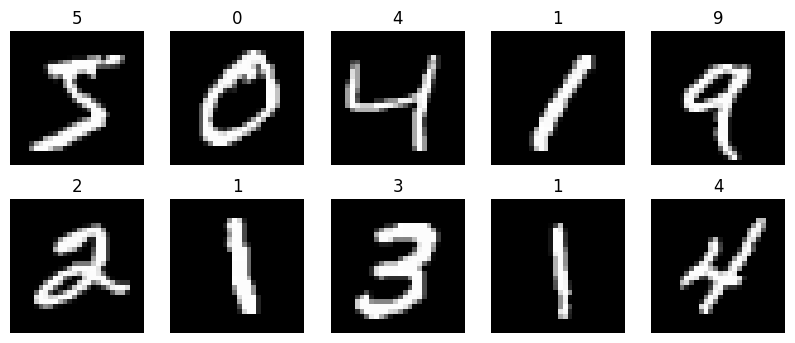

In [6]:
train_data, test_data = fetch_dataset(transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

tensor(5)
tensor(0)


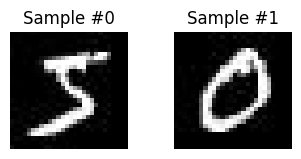

In [7]:
# Fetch "poisons"
from poisons.PoisonDataset import PoisonDataset
from os import getcwd

poisons = PoisonDataset(getcwd()+"/poisons/annot.csv", getcwd(), transform, verbose=False)


import matplotlib.pyplot as plt

fig = plt.figure()

# print((poisons[0][0]).shape)
# print((train_data.data[0]).shape)

for i, sample in enumerate(poisons):
    img, annot = sample
    print(annot)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(torch.squeeze(img), cmap="gray")

    if i == 3:
        plt.show()
        break

# print(type(poisons[0][0]))
# print(type(train_data.data))


In [8]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)

tensor([5, 6, 5, 8, 9, 3, 8, 0, 5, 4])
dataset.indcies size  600
dataset.dataset.target size  60000


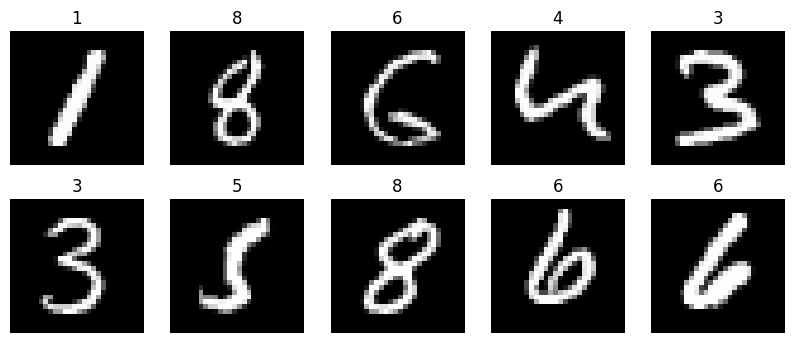

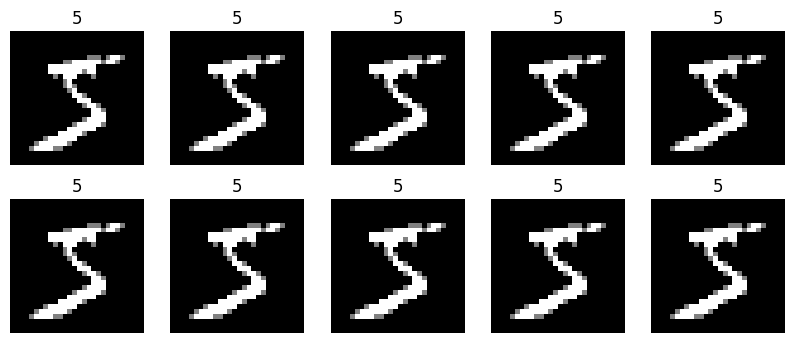

In [9]:
# "poison" the train set

'''
#zero out all labels for clients 0 ~ 5 (out of 100 clients)
for client in [0,1,2,3,4,5]:
  for idx in iid_client_train_loader[client].dataset.indices:
    iid_client_train_loader[client].dataset.dataset.targets[idx] = torch.tensor(0) 
'''
#flip labels for '7' to '1' for clients 0~5
for client in [0,1,2,3,4,5]:
  for idx in iid_client_train_loader[client].dataset.indices:
    if torch.equal(iid_client_train_loader[client].dataset.dataset.targets[idx], torch.tensor(7)):
      iid_client_train_loader[client].dataset.dataset.targets[idx] = torch.tensor(1) 

#for fun: replace all the images in client 6 with mine (currently the correct label)
for idx in iid_client_train_loader[6].dataset.indices:
  iid_client_train_loader[6].dataset.dataset.data[idx] = poisons[0][0]
  iid_client_train_loader[6].dataset.dataset.targets[idx] = poisons[0][1]

print(iid_client_train_loader[0].dataset.dataset.targets[iid_client_train_loader[0].dataset.indices[0:10]])
print("dataset.indcies size ", len(iid_client_train_loader[0].dataset.indices)) 
print("dataset.dataset.target size ", len(iid_client_train_loader[0].dataset.dataset.targets)) 
#dataset.dataset.targets 60000, original train set size
#dataset.indices 600, (train set / num clients)

img, label = next(iter(iid_client_train_loader[0]))
view_10(img, label)

img, label = next(iter(iid_client_train_loader[6]))
view_10(img, label)

## Models

In [10]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())
# print(num_params(CNN()))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


## Training

In [11]:
criterion = nn.CrossEntropyLoss()
#Validate model against specified dataloader
def validate(model, dataloader):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [12]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [13]:
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)
        
        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model, test_loader)
        print("round {}, test validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

        #test against poisons
        poison_val_acc = validate(global_model, torch.utils.data.DataLoader(poisons))
        print("round {}, poison validation acc: {}".format(t, poison_val_acc))

    return np.array(round_accuracy)


## CNN Experiments

In [14]:
cnn = CNN()
print(cnn)
# print("total params: ", num_params(cnn))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


In [15]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=5, # orig 100
                                 filename='./acc_cnn_iid_m10')
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

# on original data (10 clients per round, 5 local epochs, lr 0.01, iid data, 10 rounds): 
# global test accuracy per round: [0.9102 0.9339 0.9475 0.9568 0.9624 0.9643 0.9687 0.9712 0.9736 0.9736]

starting round 0
clients:  [26 86  2 55 75 93 16 73 54 95]
round 0, starting client 1/10, id: 26
round 0, starting client 2/10, id: 86
round 0, starting client 3/10, id: 2
round 0, starting client 4/10, id: 55
round 0, starting client 5/10, id: 75
round 0, starting client 6/10, id: 93
round 0, starting client 7/10, id: 16
round 0, starting client 8/10, id: 73
round 0, starting client 9/10, id: 54
round 0, starting client 10/10, id: 95
round 0, test validation acc: 0.9088
round 0, poison validation acc: 0.5
starting round 1
clients:  [18 29 64 92 72 87  5 15 12 17]
round 1, starting client 1/10, id: 18
round 1, starting client 2/10, id: 29
round 1, starting client 3/10, id: 64
round 1, starting client 4/10, id: 92
round 1, starting client 5/10, id: 72
round 1, starting client 6/10, id: 87
round 1, starting client 7/10, id: 5
round 1, starting client 8/10, id: 15
round 1, starting client 9/10, id: 12
round 1, starting client 10/10, id: 17
round 1, test validation acc: 0.9337
round 1, poi

In [16]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)

starting round 0
clients:  [93 49 68 23  9 67 72 82 92 85 74 76 58 39 89 77 21 69  3 54 34  5 64 65
 25 24 71 40 63 42 19  8 80 16 94 12 33 52 29 31 95 27 37 14 48  2 56  1
 28 97]
round 0, starting client 1/50, id: 93
round 0, starting client 2/50, id: 49
round 0, starting client 3/50, id: 68
round 0, starting client 4/50, id: 23
round 0, starting client 5/50, id: 9
round 0, starting client 6/50, id: 67
round 0, starting client 7/50, id: 72
round 0, starting client 8/50, id: 82
round 0, starting client 9/50, id: 92
round 0, starting client 10/50, id: 85
round 0, starting client 11/50, id: 74
round 0, starting client 12/50, id: 76
round 0, starting client 13/50, id: 58
round 0, starting client 14/50, id: 39
round 0, starting client 15/50, id: 89
round 0, starting client 16/50, id: 77
round 0, starting client 17/50, id: 21
round 0, starting client 18/50, id: 69
round 0, starting client 19/50, id: 3
round 0, starting client 20/50, id: 54
round 0, starting client 21/50, id: 34
round 0, st

KeyboardInterrupt: 

In [ ]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

In [ ]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)

In [ ]:
# view_10(x_debug[:10].to(cpu), torch.argmax(model(x_debug),dim=1)[:10].to(cpu))

# m = CNN().to(cuda)
# m.train()
# lr = 0.01
# opt = torch.optim.SGD(m.parameters(), lr)

# for epoch in range(5):
#     for (t, (x,y)) in enumerate(train_loader):
#         x = x.to(cuda)
#         y = y.to(cuda)
#         opt.zero_grad()
#         out = m(x)
#         loss = criterion(out, y)
#         loss.backward()
#         opt.step()

#         if (t%100 == 0):
#             print("epoch {}, step {}, loss: {}".format(epoch, t, loss))

#     print("running validation")
#     acc = validate(m)
#     print("epoch {} validation acc: {}".format(epoch, acc))

In [ ]:
# Small / fast CNN FedAvg experiment: 5 clients per round, 10 rounds

cnn_small = CNN()

acc_cnn_iid_small = fed_avg_experiment(
    global_model=cnn_small,
    num_clients_per_round=5,      # only 5 clients participate each round
    num_local_epochs=1,           # 1 local epoch = fast
    lr=0.01,
    client_train_loader=iid_client_train_loader,  # still 100 total clients underneath
    max_rounds=10,                # only 10 rounds
    filename='./acc_cnn_iid_small'
)

print("Per-round test accuracy:", acc_cnn_iid_small)


Injected backdoor into clients [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] with target label 7.
Total poisoned samples among malicious clients: 3497/12000 (0.291)
Client size stats -> min: 600 max: 600 avg: 600.0


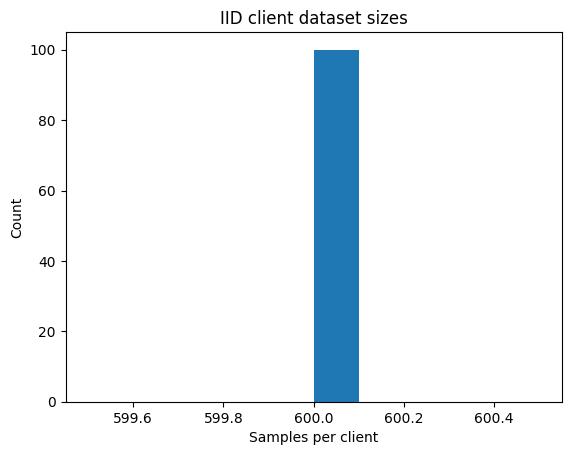

starting round 0
clients: [19 51 72 84  3]
round 0, malicious clients this round: 2/5
round 0, starting client 1/5, id: 19
round 0, starting client 2/5, id: 51
round 0, starting client 3/5, id: 72
round 0, starting client 4/5, id: 84
round 0, starting client 5/5, id: 3
round 0, clean acc: 0.2213, backdoor success: 0.8796, clean loss: 1.8750, bd loss: 1.8754, global update L2: 14.4062, benign norm: 14.4084, mal norm: 14.4061
starting round 1
clients: [ 0 17 31 35 60]
round 1, malicious clients this round: 2/5
round 1, starting client 1/5, id: 0
round 1, starting client 2/5, id: 17
round 1, starting client 3/5, id: 31
round 1, starting client 4/5, id: 35
round 1, starting client 5/5, id: 60
round 1, clean acc: 0.5627, backdoor success: 0.5032, clean loss: 1.1432, bd loss: 1.1439, global update L2: 14.4649, benign norm: 14.4687, mal norm: 14.4623
starting round 2
clients: [15 92 21 86 61]
round 2, malicious clients this round: 1/5
round 2, starting client 1/5, id: 15
round 2, starting cli

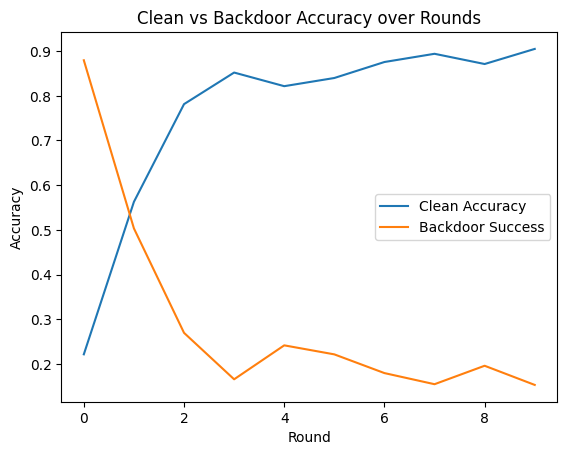

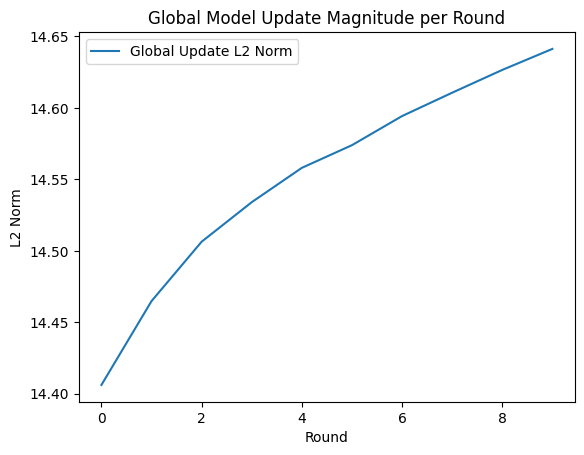

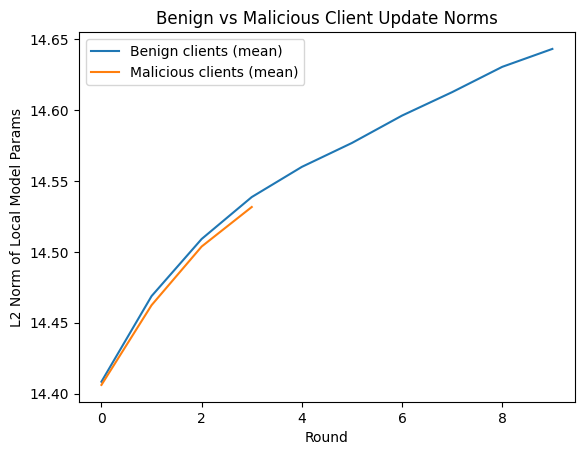

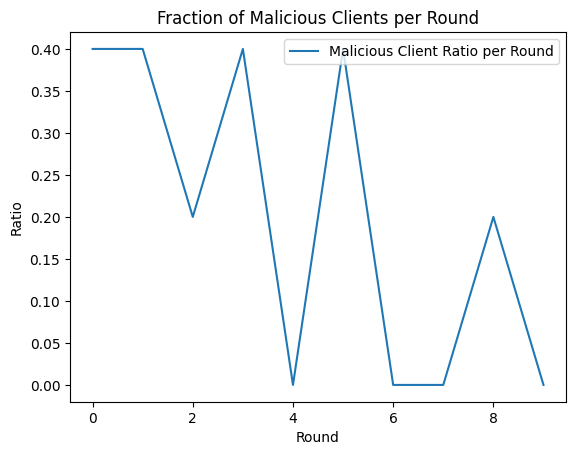

In [20]:
# ============================================================
# Small CNN FedAvg with backdoor attack + rich instrumentation
# ============================================================

from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random

# 1) Rebuild IID client loaders (100 clients as in data.py)
iid_client_train_loader = iid_partition_loader(train_data)  # default bsz=10, n_clients=100

# 2) Define a simple square trigger patch in the bottom-right corner (2x2)
def add_trigger_to_uint8(img, value=255):
    """
    img: 28x28 uint8 tensor (MNIST).
    We overwrite a 2x2 square in the bottom-right with 'value'.
    """
    img = img.clone()
    img[26:28, 26:28] = value
    return img

# 3) Inject backdoor into a subset of clients (20% malicious, 10% of their samples)
target_label = 7
malicious_clients = list(range(20))  # clients 0..19 are malicious (~20% of data)
dataset = iid_client_train_loader[0].dataset.dataset  # underlying MNIST train dataset
poison_probability = 0.1

# actually apply poisoning
for c in malicious_clients:
    indices = iid_client_train_loader[c].dataset.indices
    for idx in indices:
        if random.random() < poison_probability:
            dataset.data[idx] = add_trigger_to_uint8(dataset.data[idx])
            dataset.targets[idx] = target_label

print(f"Injected backdoor into clients {malicious_clients} with target label {target_label}.")

# 3a) Measure actual poison density
poison_count = 0
total_malicious_samples = 0

for c in malicious_clients:
    indices = iid_client_train_loader[c].dataset.indices
    for idx in indices:
        total_malicious_samples += 1
        # poisoned if patch present AND label is target_label
        if (dataset.data[idx, 26:28, 26:28] == 255).all() and dataset.targets[idx] == target_label:
            poison_count += 1

print(
    f"Total poisoned samples among malicious clients: {poison_count}/{total_malicious_samples} "
    f"({poison_count/total_malicious_samples:.3f})"
)

# 3b) Document client dataset sizes
client_sizes = [len(loader.dataset.indices) for loader in iid_client_train_loader]
print("Client size stats -> min:", min(client_sizes),
      "max:", max(client_sizes),
      "avg:", sum(client_sizes)/len(client_sizes))

plt.figure()
plt.hist(client_sizes, bins=10)
plt.title("IID client dataset sizes")
plt.xlabel("Samples per client")
plt.ylabel("Count")
plt.show()

# 4) Build a triggered test set to measure backdoor success
trigger_test_data = torchvision.datasets.MNIST(
    './data', train=False, download=True, transform=transform
)
trigger_test_data.data = trigger_test_data.data.clone()
for i in range(len(trigger_test_data.data)):
    trigger_test_data.data[i] = add_trigger_to_uint8(trigger_test_data.data[i])

trigger_test_loader = DataLoader(trigger_test_data, batch_size=256, shuffle=False)

def validate_backdoor_success(model, loader, target_label):
    """
    Fraction of triggered test images that are predicted as target_label.
    """
    model = model.to(device)
    model.eval()
    total = 0
    target_hits = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            total += preds.size(0)
            target_hits += (preds == target_label).sum().item()
    return target_hits / total if total > 0 else 0.0

def validate_loss(model, loader):
    """
    Average cross-entropy loss over a given dataloader.
    Uses global 'criterion'.
    """
    model = model.to(device)
    model.eval()
    total_loss = 0.0
    n = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            n += x.size(0)
    return total_loss / n if n > 0 else 0.0

def l2_norm_params(state_dict):
    """
    L2 norm of all parameters in a state_dict.
    """
    total = 0.0
    for p in state_dict.values():
        total += (p.float().norm() ** 2)
    return total.sqrt().item()

# 5) Small FedAvg loop (5 clients per round, 10 rounds) with instrumentation
def fed_avg_experiment_backdoor(global_model, num_clients_per_round, num_local_epochs, lr,
                                client_train_loader, max_rounds):
    round_clean_acc = []
    round_bd_success = []
    round_clean_loss = []
    round_bd_loss = []
    round_update_norm = []
    round_mal_ratio = []
    benign_update_norm_hist = []  # per-round mean benign update norm
    mal_update_norm_hist = []     # per-round mean malicious update norm

    n_clients = len(client_train_loader)

    for t in range(max_rounds):
        print(f"starting round {t}")

        # sample clients
        clients = np.random.choice(np.arange(n_clients), num_clients_per_round, replace=False)
        print("clients:", clients)

        # count malicious clients this round
        mal_count = sum([c in malicious_clients for c in clients])
        mal_ratio = mal_count / num_clients_per_round
        round_mal_ratio.append(mal_ratio)
        print(f"round {t}, malicious clients this round: {mal_count}/{num_clients_per_round}")

        global_model = global_model.to(device)
        global_model.eval()
        running_avg = None

        benign_norms_round = []
        mal_norms_round = []

        for i, c in enumerate(clients):
            print(f"round {t}, starting client {i+1}/{num_clients_per_round}, id: {c}")
            local_model = train_client(c, client_train_loader[c], global_model,
                                       num_local_epochs, lr)
            local_state = local_model.state_dict()

            # per-client update norm (just norm of local model params)
            client_update_norm = l2_norm_params(local_state)
            if c in malicious_clients:
                mal_norms_round.append(client_update_norm)
            else:
                benign_norms_round.append(client_update_norm)

            running_avg = running_model_avg(
                running_avg,
                local_state,
                1.0 / num_clients_per_round
            )

        # update global model
        global_model.load_state_dict(running_avg)

        # global update norm (after aggregation)
        global_update_norm = l2_norm_params(running_avg)
        round_update_norm.append(global_update_norm)

        # clean accuracy
        clean_acc = validate(global_model, test_loader)
        round_clean_acc.append(clean_acc)

        # backdoor success (on triggered test set)
        bd_succ = validate_backdoor_success(global_model, trigger_test_loader, target_label)
        round_bd_success.append(bd_succ)

        # clean & backdoor losses
        clean_loss = validate_loss(global_model, test_loader)
        bd_loss = validate_loss(global_model, trigger_test_loader)
        round_clean_loss.append(clean_loss)
        round_bd_loss.append(bd_loss)

        # per-round mean benign/malicious update norms
        benign_mean = float(np.mean(benign_norms_round)) if len(benign_norms_round) > 0 else np.nan
        mal_mean = float(np.mean(mal_norms_round)) if len(mal_norms_round) > 0 else np.nan
        benign_update_norm_hist.append(benign_mean)
        mal_update_norm_hist.append(mal_mean)

        print(
            f"round {t}, clean acc: {clean_acc:.4f}, "
            f"backdoor success: {bd_succ:.4f}, "
            f"clean loss: {clean_loss:.4f}, "
            f"bd loss: {bd_loss:.4f}, "
            f"global update L2: {global_update_norm:.4f}, "
            f"benign norm: {benign_mean:.4f}, "
            f"mal norm: {mal_mean:.4f}"
        )

    metrics = {
        "clean_acc": np.array(round_clean_acc),
        "bd_success": np.array(round_bd_success),
        "clean_loss": np.array(round_clean_loss),
        "bd_loss": np.array(round_bd_loss),
        "update_norm": np.array(round_update_norm),
        "mal_ratio": np.array(round_mal_ratio),
        "benign_update_norm": np.array(benign_update_norm_hist),
        "mal_update_norm": np.array(mal_update_norm_hist),
    }
    return metrics

# 6) Run the experiment
cnn_small_bd = CNN()
metrics = fed_avg_experiment_backdoor(
    global_model=cnn_small_bd,
    num_clients_per_round=5,  # 5 clients per round (small + fast)
    num_local_epochs=1,       # 1 local epoch
    lr=0.01,
    client_train_loader=iid_client_train_loader,
    max_rounds=10             # 10 rounds
)

clean_acc_hist = metrics["clean_acc"]
bd_succ_hist = metrics["bd_success"]

print("Per-round CLEAN accuracy:", clean_acc_hist)
print("Per-round BACKDOOR success:", bd_succ_hist)

# 7) Example plots for the report

plt.figure()
plt.plot(clean_acc_hist, label="Clean Accuracy")
plt.plot(bd_succ_hist, label="Backdoor Success")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Clean vs Backdoor Accuracy over Rounds")
plt.legend()
plt.show()

plt.figure()
plt.plot(metrics["update_norm"], label="Global Update L2 Norm")
plt.xlabel("Round")
plt.ylabel("L2 Norm")
plt.title("Global Model Update Magnitude per Round")
plt.legend()
plt.show()

plt.figure()
plt.plot(metrics["benign_update_norm"], label="Benign clients (mean)")
plt.plot(metrics["mal_update_norm"], label="Malicious clients (mean)")
plt.xlabel("Round")
plt.ylabel("L2 Norm of Local Model Params")
plt.title("Benign vs Malicious Client Update Norms")
plt.legend()
plt.show()

plt.figure()
plt.plot(metrics["mal_ratio"], label="Malicious Client Ratio per Round")
plt.xlabel("Round")
plt.ylabel("Ratio")
plt.title("Fraction of Malicious Clients per Round")
plt.legend()
plt.show()


In [ ]:
# ============================================================
# Defense 1: robust aggregation using coordinate-wise median
# ============================================================

def median_aggregate(state_dicts):
    """
    Coordinate-wise median aggregation over a list of client state_dicts.
    This replaces the simple average used in vanilla FedAvg.
    """
    agg = {}
    keys = state_dicts[0].keys()
    for k in keys:
        # stack tensors from all clients along a new dimension: [num_clients, ...]
        stacked = torch.stack([sd[k] for sd in state_dicts], dim=0)
        # take median across clients
        agg[k] = torch.median(stacked, dim=0).values
    return agg


def fed_avg_experiment_backdoor_median(global_model,
                                       num_clients_per_round,
                                       num_local_epochs,
                                       lr,
                                       client_train_loader,
                                       max_rounds):
    """
    Same setup as before, but the server aggregates with coordinate-wise median
    instead of simple averaging. Dataset is already poisoned.
    """
    round_clean_acc = []
    round_bd_success = []
    n_clients = len(client_train_loader)

    for t in range(max_rounds):
        print(f"[MEDIAN DEFENSE] starting round {t}")

        # sample clients (same random scheme as before)
        clients = np.random.choice(np.arange(n_clients),
                                   num_clients_per_round,
                                   replace=False)
        print("clients:", clients)

        global_model = global_model.to(device)
        global_model.eval()

        local_states = []

        for i, c in enumerate(clients):
            print(f"[MEDIAN DEFENSE] round {t}, client {i+1}/{num_clients_per_round}, id: {c}")
            local_model = train_client(c, client_train_loader[c],
                                       global_model,
                                       num_local_epochs, lr)
            local_states.append(local_model.state_dict())

        # -------- robust aggregation here --------
        median_state = median_aggregate(local_states)
        global_model.load_state_dict(median_state)
        # ----------------------------------------

        # evaluate on clean test set
        clean_acc = validate(global_model, test_loader)
        round_clean_acc.append(clean_acc)

        # evaluate on triggered test set (backdoor success)
        bd_succ = validate_backdoor_success(global_model, trigger_test_loader, target_label)
        round_bd_success.append(bd_succ)

        print(
            f"[MEDIAN DEFENSE] round {t}, clean acc: {clean_acc:.4f}, "
            f"backdoor success: {bd_succ:.4f}"
        )

    return np.array(round_clean_acc), np.array(round_bd_success)


# ------------- run defended experiment -------------
cnn_defended = CNN()
clean_acc_med, bd_succ_med = fed_avg_experiment_backdoor_median(
    global_model=cnn_defended,
    num_clients_per_round=5,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,  # same poisoned data
    max_rounds=10
)

print("MEDIAN DEFENSE - Per-round CLEAN accuracy:", clean_acc_med)
print("MEDIAN DEFENSE - Per-round BACKDOOR success:", bd_succ_med)


[MEDIAN DEFENSE] starting round 0
clients: [50 62 47 23  6]
[MEDIAN DEFENSE] round 0, client 1/5, id: 50
[MEDIAN DEFENSE] round 0, client 2/5, id: 62
[MEDIAN DEFENSE] round 0, client 3/5, id: 47
[MEDIAN DEFENSE] round 0, client 4/5, id: 23
[MEDIAN DEFENSE] round 0, client 5/5, id: 6
[MEDIAN DEFENSE] round 0, clean acc: 0.1947, backdoor success: 0.9072
[MEDIAN DEFENSE] starting round 1
clients: [ 8 53 16 19 71]
[MEDIAN DEFENSE] round 1, client 1/5, id: 8
[MEDIAN DEFENSE] round 1, client 2/5, id: 53
[MEDIAN DEFENSE] round 1, client 3/5, id: 16
[MEDIAN DEFENSE] round 1, client 4/5, id: 19
[MEDIAN DEFENSE] round 1, client 5/5, id: 71
[MEDIAN DEFENSE] round 1, clean acc: 0.6465, backdoor success: 0.4170
[MEDIAN DEFENSE] starting round 2
clients: [61 86 31 41 26]
[MEDIAN DEFENSE] round 2, client 1/5, id: 61
[MEDIAN DEFENSE] round 2, client 2/5, id: 86
[MEDIAN DEFENSE] round 2, client 3/5, id: 31
[MEDIAN DEFENSE] round 2, client 4/5, id: 41
[MEDIAN DEFENSE] round 2, client 5/5, id: 26
[MEDIAN

[SVD+IFOREST] starting round 0
clients: [94 20 93  5 95]
[SVD+IFOREST] round 0, client 1/5, id: 94
[SVD+IFOREST] round 0, client 2/5, id: 20
[SVD+IFOREST] round 0, client 3/5, id: 93
[SVD+IFOREST] round 0, client 4/5, id: 5
[SVD+IFOREST] round 0, client 5/5, id: 95
[SVD+IFOREST] round 0, inliers: 3, outliers: 2
[SVD+IFOREST] round 0, clean acc: 0.2680, backdoor success: 0.8331
[SVD+IFOREST] starting round 1
clients: [75 79  5 34 89]
[SVD+IFOREST] round 1, client 1/5, id: 75
[SVD+IFOREST] round 1, client 2/5, id: 79
[SVD+IFOREST] round 1, client 3/5, id: 5
[SVD+IFOREST] round 1, client 4/5, id: 34
[SVD+IFOREST] round 1, client 5/5, id: 89
[SVD+IFOREST] round 1, inliers: 3, outliers: 2
[SVD+IFOREST] round 1, clean acc: 0.7567, backdoor success: 0.2638
[SVD+IFOREST] starting round 2
clients: [50 92 78 11 82]
[SVD+IFOREST] round 2, client 1/5, id: 50
[SVD+IFOREST] round 2, client 2/5, id: 92
[SVD+IFOREST] round 2, client 3/5, id: 78
[SVD+IFOREST] round 2, client 4/5, id: 11
[SVD+IFOREST] r

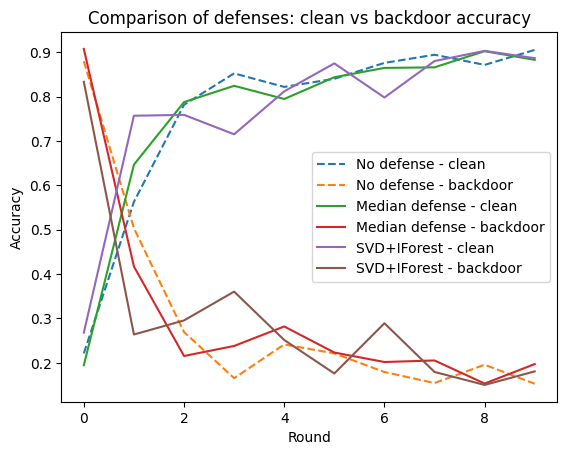

In [22]:
# ============================================================
# Defense 2: SVD + Isolation Forest anomaly detection on client updates
# ============================================================

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest
import copy

def flatten_state_dict(sd):
    """
    Flatten a state_dict into a 1D CPU tensor (for SVD/IsolationForest).
    """
    flat = []
    for p in sd.values():
        flat.append(p.detach().cpu().flatten())
    return torch.cat(flat, dim=0)

def mean_aggregate(state_dicts):
    """
    Simple mean aggregation over a list of client state_dicts.
    (Used after filtering out anomalous clients.)
    """
    agg = copy.deepcopy(state_dicts[0])
    for k in agg.keys():
        agg[k] = sum(sd[k] for sd in state_dicts) / len(state_dicts)
    return agg

def fed_avg_experiment_backdoor_svd_iforest(global_model,
                                            num_clients_per_round,
                                            num_local_epochs,
                                            lr,
                                            client_train_loader,
                                            max_rounds,
                                            contamination=0.4,
                                            svd_components=5):
    """
    FedAvg with SVD + Isolation Forest client-update anomaly detection.
    - Uses same poisoned iid_client_train_loader and trigger_test_loader.
    - For each round:
        1) Collect local client updates (delta from global model).
        2) Flatten and stack them into a matrix.
        3) Run TruncatedSVD to reduce dimensionality.
        4) Run IsolationForest on SVD features to flag outliers.
        5) Aggregate only inlier client models with mean aggregation.
    """

    round_clean_acc = []
    round_bd_success = []

    n_clients = len(client_train_loader)

    for t in range(max_rounds):
        print(f"[SVD+IFOREST] starting round {t}")

        # sample clients
        clients = np.random.choice(np.arange(n_clients),
                                   num_clients_per_round,
                                   replace=False)
        print("clients:", clients)

        global_model = global_model.to(device)
        global_model.eval()
        global_state = copy.deepcopy(global_model.state_dict())

        local_states = []
        deltas_flat = []

        for i, c in enumerate(clients):
            print(f"[SVD+IFOREST] round {t}, client {i+1}/{num_clients_per_round}, id: {c}")
            local_model = train_client(c, client_train_loader[c],
                                       global_model,
                                       num_local_epochs, lr)
            local_state = local_model.state_dict()
            local_states.append(local_state)

            # compute update delta = local - global
            delta_state = {}
            for k in global_state.keys():
                delta_state[k] = local_state[k] - global_state[k]
            deltas_flat.append(flatten_state_dict(delta_state))

        # stack client deltas into matrix [num_clients_per_round, num_params]
        updates_X = torch.stack(deltas_flat, dim=0).numpy()

        # ----------- SVD + Isolation Forest -----------
        n_components = min(svd_components, updates_X.shape[1] - 1) if updates_X.shape[1] > 1 else 1
        svd = TruncatedSVD(n_components=n_components, random_state=0)
        X_emb = svd.fit_transform(updates_X)  # low-dim embedding of updates

        # anomaly detection in SVD space
        iso = IsolationForest(contamination=contamination, random_state=0)
        labels = iso.fit_predict(X_emb)  # +1 = inlier, -1 = outlier

        inlier_indices = [i for i, lab in enumerate(labels) if lab == 1]
        outlier_indices = [i for i, lab in enumerate(labels) if lab == -1]

        print(f"[SVD+IFOREST] round {t}, inliers: {len(inlier_indices)}, outliers: {len(outlier_indices)}")

        # fallback: if all updates flagged as outliers, treat everyone as inlier
        if len(inlier_indices) == 0:
            print("[SVD+IFOREST] WARNING: all clients flagged as outliers; using all updates.")
            inlier_indices = list(range(len(local_states)))

        # aggregate only inlier states
        inlier_states = [local_states[i] for i in inlier_indices]
        aggregated_state = mean_aggregate(inlier_states)
        global_model.load_state_dict(aggregated_state)
        # ----------------------------------------------

        # evaluate on clean test set
        clean_acc = validate(global_model, test_loader)
        round_clean_acc.append(clean_acc)

        # evaluate on triggered test set (backdoor success)
        bd_succ = validate_backdoor_success(global_model, trigger_test_loader, target_label)
        round_bd_success.append(bd_succ)

        print(
            f"[SVD+IFOREST] round {t}, clean acc: {clean_acc:.4f}, "
            f"backdoor success: {bd_succ:.4f}"
        )

    return np.array(round_clean_acc), np.array(round_bd_success)


# ------------- run SVD + Isolation Forest defended experiment -------------

cnn_svd_iforest = CNN()
clean_acc_svd_if, bd_succ_svd_if = fed_avg_experiment_backdoor_svd_iforest(
    global_model=cnn_svd_iforest,
    num_clients_per_round=5,
    num_local_epochs=1,
    lr=0.01,
    client_train_loader=iid_client_train_loader,  # same poisoned data
    max_rounds=10,
    contamination=0.4,   # approx upper bound on fraction of malicious in a round
    svd_components=5
)

print("SVD+IFOREST - Per-round CLEAN accuracy:", clean_acc_svd_if)
print("SVD+IFOREST - Per-round BACKDOOR success:", bd_succ_svd_if)

# (Optional) quick plot comparison vs no-defense / median-defense
plt.figure()
plt.plot(clean_acc_hist, label="No defense - clean", linestyle="--")
plt.plot(bd_succ_hist, label="No defense - backdoor", linestyle="--")
plt.plot(clean_acc_med, label="Median defense - clean")
plt.plot(bd_succ_med, label="Median defense - backdoor")
plt.plot(clean_acc_svd_if, label="SVD+IForest - clean")
plt.plot(bd_succ_svd_if, label="SVD+IForest - backdoor")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Comparison of defenses: clean vs backdoor accuracy")
plt.legend()
plt.show()
